In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
from matplotlib import rcParams
from functools import partial

from sample_different_S import SignalGenerator

from lib.esig import expected_signature_estimate 
from lib.data.generate import generate_BM, generate_fBm, generate_MCAR, generate_Heston
from lib.utils import chop_and_shift
from lib.utils import sig_idx_to_word
from lib.exact_values.brownian_motion.esig import expected_signature_BM


In [15]:

process = 'BM'
Ns = [12] # Ns = [2, 4, 8] # is this the length of the path? 
n_samples = 1_000  # this is the NR_OF_MC_SAMPLES
max_depth = 3 # this is the depth till which we compute the signatures. 
dims = 2 # this is d = 2.
T = 1
seed = 0
H = 0.75
independent_paths = True
do_for_BM = False # setting this to true runs the code from Lorenzo's paper
# generate most granular sample
N_max=max(Ns)
length = 2 ** N_max
batch = n_samples * N_max


In [16]:
if do_for_BM:
    print("this is what they run in the paper for BM or fBM.")

    if process == 'BM':
        generate_fn=generate_BM
    elif process == 'fBm':
        generate_fn=partial(generate_fBm, H=H, use_multiprocessing=True, chunks=10)
    else:
        raise ValueError(f'Unkown process={process}.')

    if independent_paths:
        length = 2 ** N_max
        batch = n_samples * N_max
        paths=generate_fn(batch=batch, length=length, dims=dims, T=T, seed=seed)
        print("arguments passed to generate the brownian motion: ", (batch, length, dims, T, seed))
        print(" batch = ", batch)
        print(" length = ", length)
        print(" dims = ", dims)
        print(" T = ", T)
        print("seed = ", seed)
        print("shape of paths before reshaping: ", paths.shape)
        paths = paths.reshape((n_samples, N_max, 2**N_max + 1, dims))
        print(" paths after reshaping: ", paths.shape)
    else:
        paths=generate_fn(batch=n_samples, length=N_max * 2**N_max, dims=dims, T=N_max*T, seed=seed)
        print(" paths before we chop and shift: ", paths.shape)
        paths=chop_and_shift(paths, chops=2**N_max)
        print(" paths after we chop and shift: ", paths.shape)

    esig_estimates = {}
    martingale_esig_estimates = {}

    for N in Ns:
        paths_N = paths[:, :N, ::2**(N_max - N), :] # this is a really really weird way to index a path! 
        print(" N is :", N, " and the shape of paths_N is :", paths_N.shape)
        esig_estimates[N] = expected_signature_estimate(paths_N, max_depth, martingale_indices=None)
        martingale_esig_estimates[N] = expected_signature_estimate(paths_N, max_depth, martingale_indices=list(range(dims)))
        print("shapes of paths and results for the experiment:")
    print("shape of paths:")
    print(f"  paths: {paths.shape}")
    print("shape of expected signature estimates:")
    for key, value in esig_estimates.items():
        print(f"  {key}: {value.shape}")
    print("shape of martingale expected signature estimates:")
    for key, value in martingale_esig_estimates.items():
        print(f"  {key}: {value.shape}")



    rcParams.update({'text.usetex': True})

    dims = 2
    max_depth = 3
    esig_length = sum([dims**i for i in range(1, max_depth+1)])

    # Main figure
    fig = plt.figure(figsize=(len(Ns) * 8, esig_length * 4))
    outer_grid = gridspec.GridSpec(esig_length, len(Ns), wspace=1., hspace=1.)

    with_correction = True
    with_exact = True
    row_start = 0

    for depth in range(1, max_depth + 1):
        num_rows = dims ** depth
        row_end = row_start + num_rows
        

        inner_grid = gridspec.GridSpecFromSubplotSpec(num_rows, len(Ns), subplot_spec=outer_grid[row_start:row_end, :], wspace=.25, hspace=.5)

        for i in range(num_rows):
            y_max = 0
            axes = []
            for j, N in enumerate(Ns):
                ax = fig.add_subplot(inner_grid[i, j])
                I = sig_idx_to_word(row_start + i, dims)
                if j == 0:
                    ax.set_ylabel(
                        fr"""\Large{{$I = {I}$}}""",
                        rotation = 0,
                        labelpad = 50
                    )
                if row_start + i == 0:
                    ax.set_title(
                        fr"""\Large{{$N = {N}$}}""",
                        pad = 25
                    )

                if j == 0:
                    n, bins, patches = ax.hist(esig_estimates[N][:, row_start + i], bins = 100, label=r'$\hat{\phi}^{\Pi(N)}_I(T)$', alpha = 0.5 if with_correction else 1, density=True)
                    x_lims = ax.get_xlim()
                elif j > 0:
                    ax.hist(esig_estimates[N][:, row_start + i], bins = bins, label=r'$\hat{\phi}^{\Pi(N)}_I(T)$', alpha = 0.5 if with_correction else 1, density=True)
                    ax.set_xlim(*x_lims)
                
                if with_correction:
                    ax.hist(martingale_esig_estimates[N][:, row_start + i], bins=bins, label=r'$\hat{\phi}^{\Pi(N), c}_I(T)$', density=True)
                    ax.set_yscale('log')
                
                if with_exact:
                    if process == 'BM':
                        exact_value = expected_signature_BM(I, T=T, d=dims)
                    else:
                        raise ValueError(f'Unknown/unimplemented exact expected signature for process = {process}')
                    ax.scatter(exact_value, 0, s=50, color='black', label=r'$\phi_I(T)$', zorder=3, clip_on=False)


                y_max = max(y_max, ax.get_ylim()[-1])
                
                ax.xaxis.set_major_formatter(ScalarFormatter())
                ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}')) 
                ax.set_yticks([])
                ax.set_yticklabels([])

                axes.append(ax)
            
            # set same y_lims
            for ax in axes:
                ax.set_ylim(0, y_max)

        row_start = row_end

        handles, labels = ax.get_legend_handles_labels()
        unique_labels = dict(zip(labels, handles))
        fig.legend(unique_labels.values(), unique_labels.keys(), loc='lower center', ncol=len(unique_labels))

        fig.tight_layout()
        plt.show()

In [17]:
sig_gen = SignalGenerator()

OU_path = sig_gen.sample_s(d = dims, n = (length + 1) * batch, ts_type='ARMA')
print(" shape of OU_path before reshaping: ", OU_path.shape)
OU_path = OU_path.reshape((n_samples, N_max, 2**N_max + 1, dims))
print(" shape of OU_path after reshaping: ", OU_path.shape)



 p =  10
 shape of OU_path before reshaping:  (49164000, 2)
 shape of OU_path after reshaping:  (1000, 12, 4097, 2)


In [12]:
N = max(Ns)
esig_estimates_OU = {}
martingale_esig_estimates_OU = {}
esig_estimates_OU[N] = expected_signature_estimate(OU_path, max_depth, martingale_indices=None)
martingale_esig_estimates_OU[N] = expected_signature_estimate(OU_path, max_depth, martingale_indices=list(range(dims)))

/var/folders/8j/_z3hb0md2ts8q3jtwg2ty3j00000gn/T/ipykernel_76929/4251594399.py:71: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, y_max)
/var/folders/8j/_z3hb0md2ts8q3jtwg2ty3j00000gn/T/ipykernel_76929/4251594399.py:71: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, y_max)
/var/folders/8j/_z3hb0md2ts8q3jtwg2ty3j00000gn/T/ipykernel_76929/4251594399.py:71: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, y_max)
/var/folders/8j/_z3hb0md2ts8q3jtwg2ty3j00000gn/T/ipykernel_76929/4251594399.py:71: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, y_max)
/var/folders/8j/_z3hb0md2ts8q3jtwg2ty3j00000gn/T/ipykernel_76929/4251594399.py:71: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, y_max)
/var/folders/8j/_z3hb0md2ts8q3jtwg2ty3j00000g

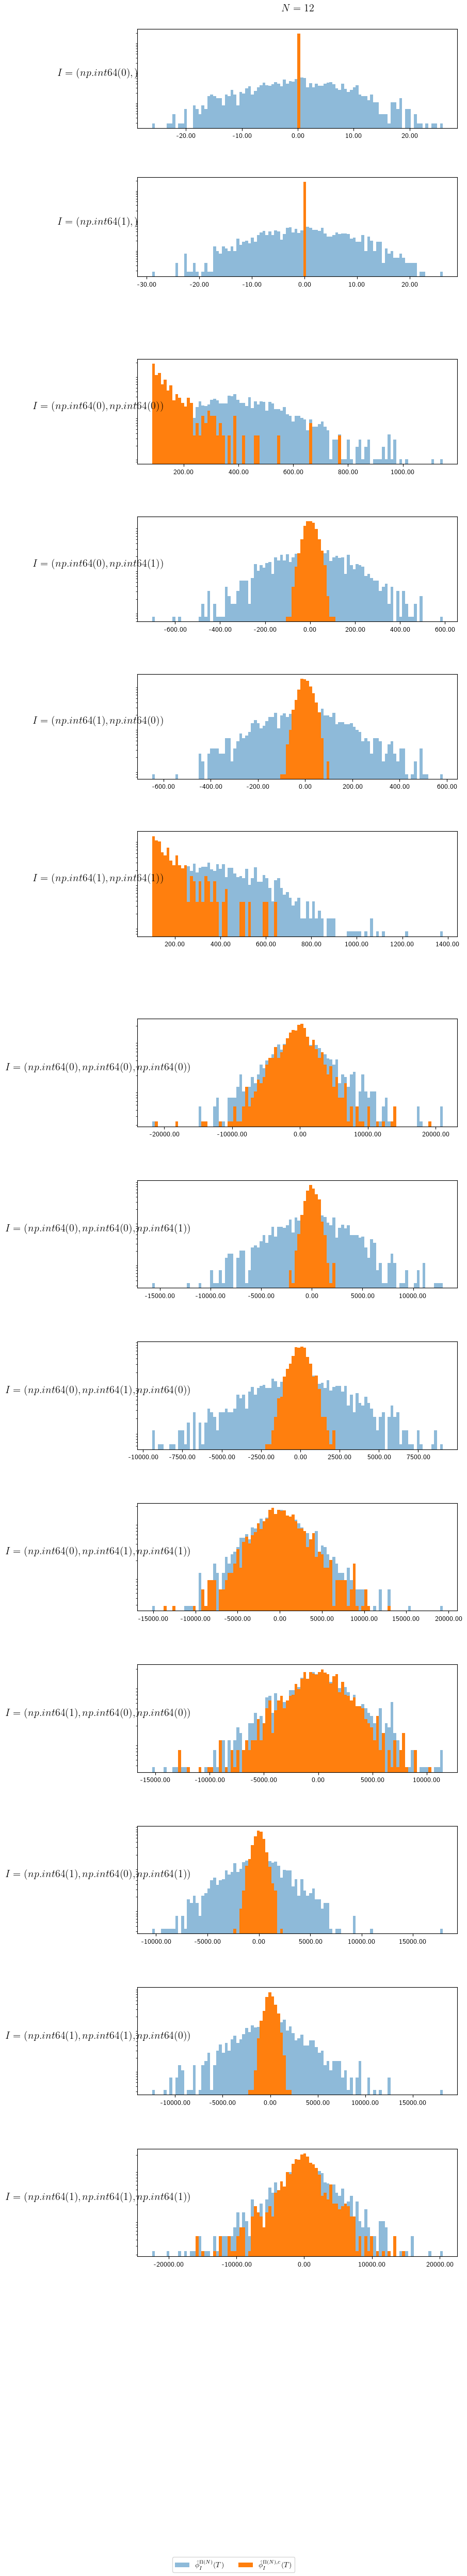

In [18]:
# genereate the same plot for the samples stored in esig_estimates_OU and martingale_esig_estimates_OU:
rcParams.update({'text.usetex': True})

dims = 2
max_depth = 3
esig_length = sum([dims**i for i in range(1, max_depth+1)])

# Main figure
fig = plt.figure(figsize=(len(Ns) * 8, esig_length * 4))
outer_grid = gridspec.GridSpec(esig_length, len(Ns), wspace=1., hspace=1.)

with_correction = True
with_exact = False
row_start = 0

for depth in range(1, max_depth + 1):
    num_rows = dims ** depth
    row_end = row_start + num_rows
    

    inner_grid = gridspec.GridSpecFromSubplotSpec(num_rows, len(Ns), subplot_spec=outer_grid[row_start:row_end, :], wspace=.25, hspace=.5)

    for i in range(num_rows):
        y_max = 0
        axes = []
        for j, N in enumerate(Ns):
            ax = fig.add_subplot(inner_grid[i, j])
            I = sig_idx_to_word(row_start + i, dims)
            if j == 0:
                ax.set_ylabel(
                    fr"""\Large{{$I = {I}$}}""",
                    rotation = 0,
                    labelpad = 50
                )
            if row_start + i == 0:
                ax.set_title(
                    fr"""\Large{{$N = {N}$}}""",
                    pad = 25
                )

            if j == 0:
                n, bins, patches = ax.hist(esig_estimates_OU[N][:, row_start + i], bins = 100, label=r'$\hat{\phi}^{\Pi(N)}_I(T)$', alpha = 0.5 if with_correction else 1, density=True)
                x_lims = ax.get_xlim()
            elif j > 0:
                ax.hist(esig_estimates_OU[N][:, row_start + i], bins = bins, label=r'$\hat{\phi}^{\Pi(N)}_I(T)$', alpha = 0.5 if with_correction else 1, density=True)
                ax.set_xlim(*x_lims)
            
            if with_correction:
                ax.hist(martingale_esig_estimates_OU[N][:, row_start + i], bins=bins, label=r'$\hat{\phi}^{\Pi(N), c}_I(T)$', density=True)
                ax.set_yscale('log')
            
            if with_exact:
                if process == 'BM':
                    exact_value = expected_signature_BM(I, T=T, d=dims)
                else:
                    raise ValueError(f'Unknown/unimplemented exact expected signature for process = {process}')
                ax.scatter(exact_value, 0, s=50, color='black', label=r'$\phi_I(T)$', zorder=3, clip_on=False)


            y_max = max(y_max, ax.get_ylim()[-1])
            
            ax.xaxis.set_major_formatter(ScalarFormatter())
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}')) 
            ax.set_yticks([])
            ax.set_yticklabels([])

            axes.append(ax)
        
        # set same y_lims
        for ax in axes:
            ax.set_ylim(0, y_max)

    row_start = row_end

handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
fig.legend(unique_labels.values(), unique_labels.keys(), loc='lower center', ncol=len(unique_labels))

fig.tight_layout()
plt.show()


In [19]:
esig_means = {N: np.mean(esig_estimates_OU[N], axis=0) for N in Ns}
martingale_esig_means = {N: np.mean(martingale_esig_estimates_OU[N], axis=0) for N in Ns}

print(esig_means)
print(martingale_esig_means)

{12: array([ 1.64e-02,  2.14e-02,  4.29e+02,  4.67e+00, -4.49e-01,  4.22e+02,
        1.60e+02,  4.25e+01, -6.95e+01,  9.09e+01, -8.39e+01, -1.10e+02,
        3.33e+01,  1.07e+02])}
{12: array([   0.  ,    0.  ,   69.75,    2.01,    1.57,   70.3 , -262.03,
         -9.46,   -5.15,   46.24,  -51.6 ,    3.49,   18.99, -153.53])}


In [21]:
def get_lev_2_mat(arr) -> np.ndarray:
    # (d*d,) → (d, d)
    return arr[dims: dims + dims**2].reshape((dims, dims))

def get_lev_3_mat(arr) -> np.ndarray:
    # (d*d*d,) → (d, d, d)
    return arr[dims + dims**2:].reshape((dims, dims, dims))

l2mat = get_lev_2_mat(esig_means[N])
l2mat = np.expand_dims(l2mat, axis=0)
l3mat = get_lev_3_mat(esig_means[N])
Mu_matrices = np.concatenate([l2mat, l3mat], axis=0)

martingale_l2 = get_lev_2_mat(martingale_esig_means[N])
martingale_l2 = np.expand_dims(martingale_l2, axis=0)
martingale_l3 = get_lev_3_mat(martingale_esig_means[N])
Mu_matrices_martingale = np.concatenate([martingale_l2, martingale_l3], axis=0)

print("Mu_matrices: ", Mu_matrices)
print("Mu_matrices martingale corrected: ", Mu_matrices_martingale)

Mu_matrices:  [[[ 428.65    4.67]
  [  -0.45  421.9 ]]

 [[ 160.24   42.54]
  [ -69.48   90.88]]

 [[ -83.87 -110.5 ]
  [  33.28  106.87]]]
Mu_matrices martingale corrected:  [[[  69.75    2.01]
  [   1.57   70.3 ]]

 [[-262.03   -9.46]
  [  -5.15   46.24]]

 [[ -51.6     3.49]
  [  18.99 -153.53]]]


In [22]:
class ContrastCalculator:
    def compute_N_fromM2(self, M2: np.ndarray) -> np.ndarray:
        """takes the signal nu and computes the N matrix, which is diagonal with entries sqrt<mu>_ii

        Args:
            M2 (np.ndarray): signal of shape (d, d)

        Returns:
            np.ndarray: N matrix of shape (d, d)
        """
        diag = np.sqrt(np.diag(M2))
        res = np.diag(diag)
        if np.linalg.cond(res) > 1e3:
            warnings.warn("N nearly singular")
            print("N matrix is: \n", res)
            print("M2 matrix is: \n", M2)
        return res

    def get_Mu_star_matrices(self, Mu_matrices: np.ndarray) -> np.ndarray:
        """returns the Mu_star matrices, which are the Mu matrices in the perfectly IC case.

        Args:
            Mu_matrices (np.ndarray): shape (d+1, d, d)

        Returns:
            np.ndarray: shape (d+1, d, d)
        """
        Mu_only2 = Mu_matrices[0]  # (d, d)
        Mu_only3 = Mu_matrices[1:]  # (d, d, d)
        Mu_star = np.zeros_like(Mu_matrices)
        Mu_star[0] = np.diag(np.diag(Mu_only2))  # D[0] is the diagonal of M2
        # for level 3
        for k in range(0, dims):
            D = np.zeros_like(Mu_only3[k])
            D[k, k] = Mu_only3[k, k, k]
            Mu_star[k + 1] = D
        return Mu_star

    def compute_delta(self, Mu_matrices:np.ndarray) -> float:
        """computes the IC-defect delta for the sources S.

        Args:
            S (np.ndarray): shape(n, d)

        Returns:
            float: delta (IC-defect)
        """
        print("Coredinates (Mu_matrices) of the sources S are: \n", Mu_matrices)

        N = self.compute_N_fromM2(Mu_matrices[0])
        eps = 1e-16
        if np.linalg.cond(N) > 1e3:
            warnings.warn("N nearly singular")
            print("N matrix is: \n", N)
            print("Mu matrices are: \n", Mu_matrices)
        # add eps * Id to N to make it invertible
        N = N + eps * np.eye(N.shape[0])
        Ninv = np.linalg.inv(N)

        denominator = [1.0]
        denominator.extend(np.diag(N))
        denominator = np.array(denominator)  # (d+1,)

        Mu_star_matrices = self.get_Mu_star_matrices(Mu_matrices)

        difference = Mu_matrices - Mu_star_matrices

        sum_sq = 0.0
        for k in range( dims + 1):
            k_th_component = np.linalg.norm(Ninv @ (difference[k] / denominator[k]) @ Ninv, 'fro')**2
            sum_sq += k_th_component
        res = np.sqrt(sum_sq)
        
        return res

contrastcalc = ContrastCalculator()

delta_normal = contrastcalc.compute_delta(Mu_matrices)
print("Using the martingale correction:")
delta_martingale = contrastcalc.compute_delta(Mu_matrices_martingale)
print("delta (normal): ", delta_normal)
print("delta (martingale): ", delta_martingale)

Coredinates (Mu_matrices) of the sources S are: 
 [[[ 428.65    4.67]
  [  -0.45  421.9 ]]

 [[ 160.24   42.54]
  [ -69.48   90.88]]

 [[ -83.87 -110.5 ]
  [  33.28  106.87]]]
Using the martingale correction:
Coredinates (Mu_matrices) of the sources S are: 
 [[[  69.75    2.01]
  [   1.57   70.3 ]]

 [[-262.03   -9.46]
  [  -5.15   46.24]]

 [[ -51.6     3.49]
  [  18.99 -153.53]]]
delta (normal):  0.02409797725868313
delta (martingale):  0.1293744496972782
